# 实作DCGAN演算法，产生手写阿拉伯数字
### 程式修改自[Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)

In [1]:
# To generate GIFs
!pip install -q imageio

In [2]:
# 载入相关套件
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display

## 取得训练资料，转为TensorFlow Dataset

In [3]:
# 取得 MNIST 训练资料
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# 像素标准化
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # 使像素值介于 [-1, 1]

# 参数设定
BUFFER_SIZE = 60000 # 缓冲区大小
BATCH_SIZE = 256    # 训练批量

# 转为 Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
        .shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(BUFFER_SIZE).cache()

## 定义生成神经网路

In [4]:
# 生成神经网路
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # None 代表批量不检查

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), 
                     padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

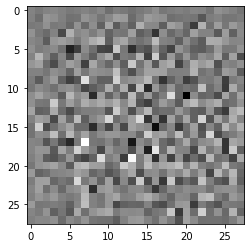

In [5]:
# 产生生成神经网路
generator = make_generator_model()

# 测试产生的杂讯
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# 显示杂讯生成的图像
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## 定义判别神经网路

In [6]:
# 判别神经网路
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
# 测试判别神经网路
discriminator = make_discriminator_model()

# 真实的影像预测值会是较大的值，生成的影像预测值会是较小的值
decision = discriminator(generated_image)
print (f'预测值={decision}')

预测值=[[0.00080222]]


In [8]:
# 测试真实的影像 5 笔
decision = discriminator(train_images[0:5])
print (f'预测值={decision}')

预测值=[[ 0.10496937]
 [ 0.11921558]
 [-0.08852884]
 [-0.01600663]
 [-0.02467511]]


## 定义损失函数及优化器

In [9]:
# 定义损失函数为二分类交叉熵
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 定义判别神经网路损失函数为 真实影像 + 生成影像 的损失函数
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 定义生成神经网路损失函数为 生成影像 的损失函数
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 优化器均为 Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 设定检查点

In [10]:
# 在检查点模型存档
checkpoint_dir = './dcgan_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                  discriminator_optimizer=discriminator_optimizer,
                  generator=generator,
                  discriminator=discriminator)

## 参数设定

In [11]:
# 参数设定
EPOCHS = 50                    # 训练执行周期
noise_dim = 100                # 杂讯向量大小
num_examples_to_generate = 16  # 生成笔数

# 产生乱数(杂讯)
seed = tf.random.normal([num_examples_to_generate, noise_dim]) 

## 定义梯度下降函数

In [12]:
# 定义梯度下降，分别对判别神经网路、生成神经网路进行训练
@tf.function  # 产生运算图
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 生成神经网路进行训练
        generated_images = generator(noise, training=True)

        # 判别神经网路进行训练
        real_output = discriminator(images, training=True)           # 真实影像
        fake_output = discriminator(generated_images, training=True) # 生成影像

        # 计算损失
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 梯度下降
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)

    # 更新权重
    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

## 定义训练函数

In [13]:
# 定义训练函数
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 产生图像
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 每 10 个执行周期存档一次
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('epoch {} 花费 {} 秒'.format(epoch + 1, time.time()-start))

    # 显示最后结果
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [14]:
# 产生图像并存档
def generate_and_save_images(model, epoch, test_input):
    # 预测
    predictions = model(test_input, training=False)

    # 显示 4x4 的格子
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

    # 存档
    plt.savefig('./GAN_result/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## 训练模型

In [15]:
import os
if not os.path.exists('./GAN_result'):
  os.makedirs('./GAN_result')

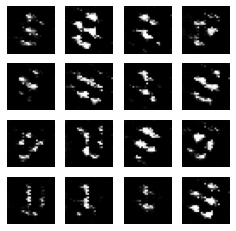

epoch 4 花费 279.1416504383087 秒


KeyboardInterrupt: 

In [16]:
train(train_dataset, EPOCHS)

## 显示最后结果

In [ ]:
# 显示最后结果
def display_image(epoch_no):
    return PIL.Image.open('./GAN_result/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

## 将训练过程的存档图像转为GIF 档，并显示GIF档

In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [ ]:
# 产生 GIF 档
anim_file = './GAN_result/dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./GAN_result/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        # print(filename)
        image = imageio.imread(filename)
        writer.append_data(image)
    
# 显示 GIF 档
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)